In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
import xgboost as xgb
import json

save_result = 'DECILE_PUNT_GLOBAL' #-> run this notebook to save the predictions for this label!

# XGBoost

In [2]:
# Data directory
data_dir = "../../../data/unziped_data/"

# Open data with pickle
data_for_training = "../../../data/Data_For_Training/"
data_original = pd.read_csv(data_for_training + "icfes_20182.csv")

# lista de las columnas con las caracteristicas a predecir
notasz = [c for c in data_original.columns.values if c.startswith("NOTA_Z")]
deciles = [c for c in data_original.columns.values if c.startswith("DECILE")]
labels_names = notasz + deciles
puntajes = [decil.replace('DECILE_','') for decil in deciles]


# lista de las columnas que se van a omitir de las caracteristicas
vars_2_omit = (
    [
     'PUNT_LECTURA_CRITICA', 
     'PERCENTIL_LECTURA_CRITICA', 
     'DESEMP_LECTURA_CRITICA', 
     'PUNT_MATEMATICAS', 
     'PERCENTIL_MATEMATICAS', 
     'DESEMP_MATEMATICAS', 
     'PUNT_C_NATURALES', 
     'PERCENTIL_C_NATURALES', 
     'DESEMP_C_NATURALES', 
     'PUNT_SOCIALES_CIUDADANAS', 
     'PERCENTIL_SOCIALES_CIUDADANAS', 
     'DESEMP_SOCIALES_CIUDADANAS', 
     'PUNT_INGLES', 
     'PERCENTIL_INGLES', 
     'DESEMP_INGLES', 
     'PUNT_GLOBAL', 
     'PERCENTIL_GLOBAL', 
    ]
    + deciles
    + notasz
)




labels = data_original[labels_names]
features = data_original.drop(vars_2_omit, axis=1)
#features_train, features_test, labels_train, labels_test = train_test_split(
#    features, labels, test_size=0.2, random_state=42
#)
# Mascara para los modelos que predicen la Nota Z
mask_nota_z = [False if 'COLE' in col or 'DEPTO' in col or 'MCPIO' in col or "ESTABLECIMIENTO" in col else True for col in features.columns]

In [3]:
#Cargar los escaladores
scaler_features = pickle.load(open("../models/scaler_features_20182.pkl", "rb"))
scaler_labels = pickle.load(open("../models/scaler_labels_20182.pkl", "rb"))
# Escalar las caracteristicas
X = scaler_features.transform(features)
Y = scaler_labels.transform(labels)
# Hacer las predicciones de los resultados
Y_pred = np.zeros(labels.shape)
Y_pred.fill(np.nan)
for ii in range(len(labels_names)):
    print(labels_names[ii])
    bst = xgb.Booster({'nthread': 4})  # init model
    bst.load_model("../models/icfes_20182_{0}.model".format(labels_names[ii]))
    idx = np.where(~np.isnan(Y[:, ii]))
    if "NOTA_Z" in labels_names[ii]:
        dtotal = xgb.DMatrix(X[idx[0]][:, mask_nota_z])
    else:
        dtotal = xgb.DMatrix(X[idx[0]])
    ypred = bst.predict(dtotal)
    Y_pred[idx[0],ii] = ypred
#Crear dataframe con labels no escaladas y prediciones no escaladas
Y_pred_real = scaler_labels.inverse_transform(Y_pred)
pred_lables = [label+'_pred' for label in labels_names]
columns = features.columns.to_list() + puntajes + labels_names + pred_lables
total_data = np.concatenate((features.values,data_original[puntajes].values, labels.values,Y_pred_real),axis=1)
data = pd.DataFrame(data=total_data,columns=columns)

/home/trucupey/.virtualenvs/ICFES-SocioEconomico-Qp25LKX0/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


NOTA_Z_COLE_CODIGO_ICFES_PUNT_MATEMATICAS
NOTA_Z_COLE_CODIGO_ICFES_PUNT_LECTURA_CRITICA
NOTA_Z_COLE_CODIGO_ICFES_PUNT_C_NATURALES
NOTA_Z_COLE_CODIGO_ICFES_PUNT_SOCIALES_CIUDADANAS
NOTA_Z_COLE_CODIGO_ICFES_PUNT_INGLES
NOTA_Z_COLE_CODIGO_ICFES_PUNT_GLOBAL
DECILE_PUNT_MATEMATICAS
DECILE_PUNT_LECTURA_CRITICA
DECILE_PUNT_C_NATURALES
DECILE_PUNT_SOCIALES_CIUDADANAS
DECILE_PUNT_INGLES
DECILE_PUNT_GLOBAL


_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_MATEMATICAS
[[158641  91921]
 [ 92686 206686]]
presicion 63.3%
recall 63.1%
accuracy 66.3%


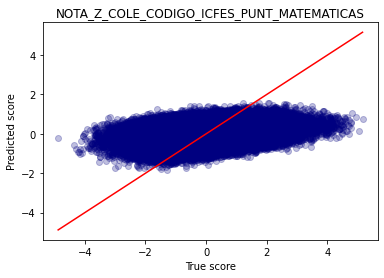

_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_LECTURA_CRITICA
[[151513  98056]
 [ 93427 206938]]
presicion 60.7%
recall 61.9%
accuracy 65.7%


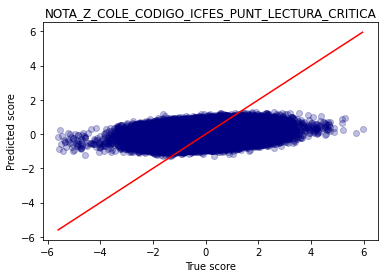

_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_C_NATURALES
[[153310  92068]
 [ 91247 213309]]
presicion 62.5%
recall 62.7%
accuracy 66.8%


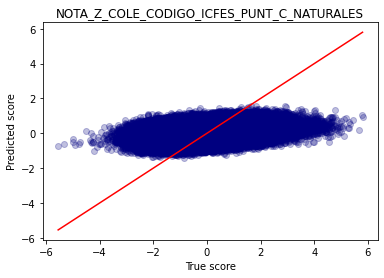

_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_SOCIALES_CIUDADANAS
[[149343  93551]
 [ 92230 214810]]
presicion 61.5%
recall 61.8%
accuracy 66.4%


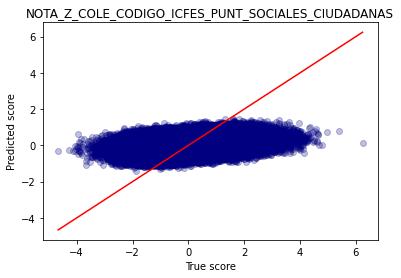

_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_INGLES
[[139093 102983]
 [ 92728 215130]]
presicion 57.5%
recall 60.0%
accuracy 65.6%


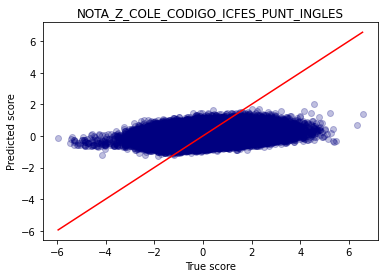

_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_GLOBAL
[[157468  83213]
 [ 89117 220136]]
presicion 65.4%
recall 63.9%
accuracy 67.9%


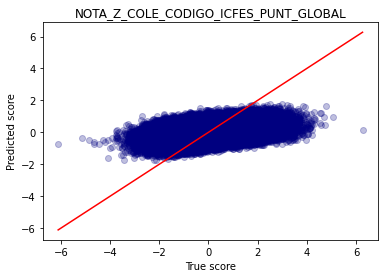

51.00010564037267   511
_________________________________________
PUNT_MATEMATICAS
[[205825  62543]
 [ 61336 220230]]
presicion 76.7%
recall 77.0%
accuracy 77.6%


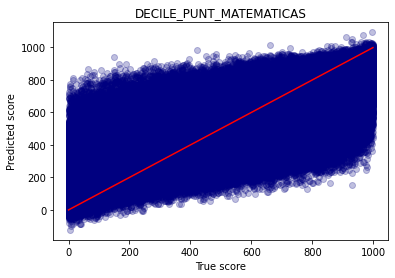

53.0000720966715   502
_________________________________________
PUNT_LECTURA_CRITICA
[[199578  73739]
 [ 69992 206625]]
presicion 73.0%
recall 74.0%
accuracy 74.4%


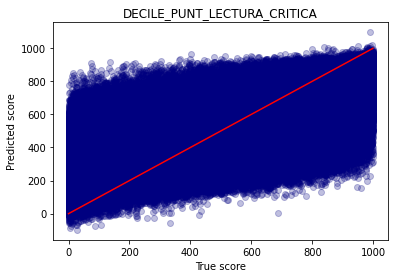

50.000271348753486   518
_________________________________________
PUNT_C_NATURALES
[[199279  65239]
 [ 58465 226951]]
presicion 75.3%
recall 77.3%
accuracy 78.5%


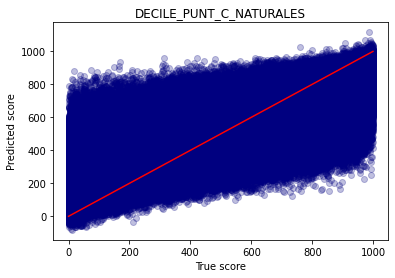

49.00021164769986   534
_________________________________________
PUNT_SOCIALES_CIUDADANAS
[[173359  82360]
 [ 55036 239179]]
presicion 67.8%
recall 75.9%
accuracy 78.9%


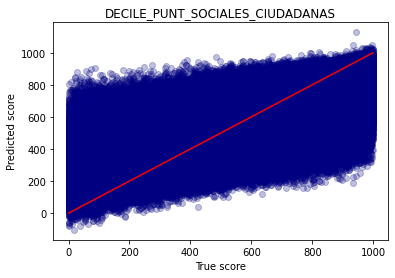

51.00027551570069   541
_________________________________________
PUNT_INGLES
[[170187  81673]
 [ 48705 249369]]
presicion 67.6%
recall 77.7%
accuracy 81.2%


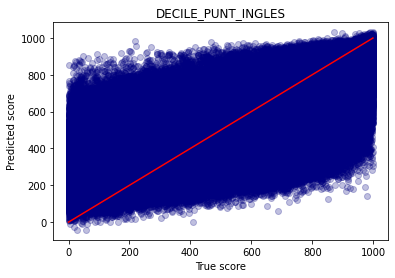

251.0072391303005   523
_________________________________________
PUNT_GLOBAL
[[199952  61817]
 [ 53103 235062]]
presicion 76.4%
recall 79.0%
accuracy 80.4%


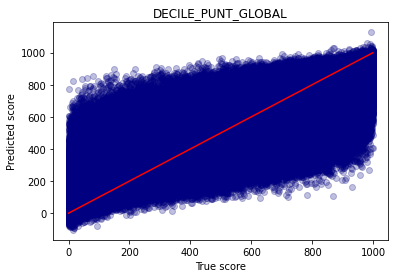

In [6]:
save_result = 'DECILE_PUNT_GLOBAL' #-> run this notebook to save the predictions for this label!
for label in labels_names:
    if 'DECIL' in label:
        puntaje = label.replace('DECILE_','')
        np.random.seed(0)
        maxval = data_original[puntaje].max()
        minval = data_original[puntaje].min()
        size = data_original[puntaje].shape[0]
        rangeval = (maxval - minval) / 10000
        data_original[puntaje+'_plus_noise'] = data_original[puntaje] + np.random.uniform(0, rangeval, size)
        mililes = data_original[puntaje+'_plus_noise'].quantile([ii/1000 for ii in range(1,1000)]).values
        mean_puntaje = data_original[puntaje].mean()
        for ii in range(len(mililes)):
            if mililes[ii] >= mean_puntaje:
                reference_value = ii + 1
                print(mililes[ii],' ',ii)
                break    
    else:
        puntaje = label
        reference_value = 0
    data['{}_above_average'.format(label)] = data[label].apply(lambda x: 
            'Above' if x >= reference_value else 'Below')
    data['{}_pred_above_average'.format(label)] = data['{}_pred'.format(label)].apply(lambda x: 
            'Above' if x >= reference_value else 'Below')
    y_real = data['{}_above_average'.format(label)].tolist()
    y_pred = data['{}_pred_above_average'.format(label)].tolist()
    cm = confusion_matrix(y_real,y_pred, labels=['Above','Below'] )
    print('_________________________________________')
    print(puntaje)
    print(cm)
    print('presicion {:.1f}%'.format(cm[0,0]*100/(cm[0,0]+cm[0,1])))
    print('recall {:.1f}%'.format(cm[0,0]*100/(cm[0,0]+cm[1,0]))) 
    print('accuracy {:.1f}%'.format((cm[0,0]+cm[1,1])*100/(cm[0,0]+cm[1,0]+cm[1,0]+cm[1,1]))) 
    y_real = data[label].values
    y_pred = data['{}_pred'.format(label)].values
    fig, ax = plt.subplots()
    ax.scatter(y_real, y_pred, alpha=0.25, color='navy')
    ax.set_title(label)
    ax.set_xlabel('True score')
    ax.set_ylabel('Predicted score')
    #axins = ax.inset_axes([0.03, 0.5, 0.47, 0.47])
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Above', 'Below'])
    #disp = disp.plot(cmap='viridis', xticks_rotation='horizontal', ax=axins)
    minx = np.min(y_real[~np.isnan(y_real)])
    maxx = np.max(y_real[~np.isnan(y_real)])
    ax.plot([minx, maxx], [minx, maxx], ls='-', color='red')
    if label == save_result:
        plt.savefig('../XGBoost_error_dispersion_plot.png', dpi=300, bbox_inches='tight')
    plt.show()   